In [1]:
!pip install quantecon_book_networks
!pip install quantecon pandas-datareader

# An Introduction to Production Networks with Python

Author: [Shu Hu](https://shu-hu.com/)

This notebook teaches you what a production network is and how we can use it for economic analysis.

## 1 Overview

- motivation
- background check and things to cover
    - background: english, math, python
    - things to cover: 
        - visualise production
        - define production networks (input-output networks)
        - applications
- reference
    - https://intro.quantecon.org/input_output.html
    - https://python.quantecon.org/geom_series.html
    - https://networks.quantecon.org/
    
Here are some imports:

In [36]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import quantecon_book_networks
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data
import matplotlib as mpl
from matplotlib.patches import Polygon

And set the style for plots.

In [37]:
quantecon_book_networks.config("matplotlib")
mpl.rcParams.update(mpl.rcParamsDefault)

### 1.1 Motivation

figure: https://intro.quantecon.org/input_output.html#us-15sectors

interpret:
- data source
- components: node, edge, arrow, size, color

code (optional)

background: [Leontief](https://en.wikipedia.org/wiki/Wassily_Leontief) input-output model (equivalently, the production network)

## 2 Production networks

### 2.1 Basic setups

Assume an economy with
- $n$ sectors each produces one final good
- $1$ exogenous input (labor)

The Leontief production function describes technology for producing good $j \in \{ 1, \cdots, n \}$ 

$$
x_j = \min_{ i \in \{0, \cdots, n \} } \left ( \frac{z_{ij}}{a_{ij}} \right ) \tag{1}
$$

For $j = 1, \cdots, n$, $i = 1, \cdots, n$
- $x_0$ the amount of labor
- $x_j$ the gross output of final good $j$
- $z_{ij}$ quantity of good $i$ allocated to be an input to producing good $j$
- $z_{0j}$ quantity of labor allocated to producing good $j$.
- $a_{ij}$ the number of units of good $i$ required to produce one unit of good $j$
- $a_{0j}$ the number of units of labor required to produce one unit of good $j$

Let 
- $d_j$ net output of final good $j$ available for final consumption
- $x = (x_1, \cdots, x_n)$, 
- $d= (d_1, \cdots, d_n)$, 
- $A= (a_{ij})$ and 
- $a_0 = (a_{01}, \cdots, a_{0n})$.

Input output model can be described by

$$
x \geq A x + d \tag{2}
$$
and
$$
a^{\top}_0 x \leq x_0 \tag{3}
$$

#### Example 1

Consider a two good economy where $A$ and $d$ are given by

In [38]:
A = np.array([[0.1, 40],
             [0.01, 0]])

d = np.array([50, 2]).reshape((2, 1))

### 2.2 Leontief inverse

We can solve (2) for 

$$
x = (I-A)^{-1} d \equiv Ld \tag{4}
$$

where $L=(I-A)^{-1}$ is called the Leontief inverse if it exists.

The Hawkins-Simon condition specifies 

$$
\label{eq5}
\det (I-A) >0 \tag{5}
$$
and

$$
\label{eq6}
(I-A)_{ij} >0, i = j \tag{6}
$$

If Hawkins-Simm condition $(5)$ and $(6)$ is satisfied, then $x$ is a positive vector.

#### Example 

Consider example 1, we can check the Hawkins-Simon conditions

In [39]:
I = np.identity(2)
B = I - A
np.linalg.det(B) > 0 # checking Hawkins-Simon conditions

True

And compute the Leontief inverse matrix

In [40]:
L = np.linalg.inv(B) # obtaining Leontieff inverse matrix
L

array([[2.0e+00, 8.0e+01],
       [2.0e-02, 1.8e+00]])

And solve for $x$

In [41]:
x = L @ d   # solving for gross ouput
x

array([[260. ],
       [  4.6]])

### 2.3 Production possibility frontier

(3) can be rewritten as

$$
a^{\top}_0 x = x_0 \tag{7}
$$

If $L$ exists, the plugging $x = (I-A)^{-1} d$ into (7) yields

$$
A^{\top}_0 d = x_0 \tag{8}
$$

where $A^{\top}_0 = a^{\top}_0 L$.

(8) is the production possibility frontier of final consumption bundles $d$ that can be produced with exogenous labor input $x_0$.

#### Example

Suppose $a^{\top}_0$ is

In [42]:
a0 = np.array([4, 100])

Then we can find $A^{\top}$

In [43]:
A0 = a0 @ L
A0

array([ 10., 500.])

So the production possibility frontier is

$$
10 d_1 + 500 d_2 = x_0
$$

### 2.4 Relative prices

Since the price of each good equals total production cost, which is the sum of intermediate input cost and labor cost,

$$
p_j = \sum_{i} a_{ij} p_i + a_{0j} w \tag{9}
$$
$\forall j = 1, \cdots, n$.

Rewrite it in the matrix form

$$
p = A^{\top} p + a_0 w \tag{10}
$$

We can solve (10) for 

$$
p = (I- A^{\top})^{-1} a_0 w \tag{11}
$$

Note that (10) and (2) form a conjugate pair.

#### Example

Suppose the wage is 

In [13]:
w = 2

The relative price is

In [14]:
B_trans = np.transpose(B)
p = np.linalg.inv(B_trans) @ a0 * w
p

array([  20., 1000.])

## 3 Application i: demand shock analysis

By the [Neumann series lemma](https://en.wikipedia.org/wiki/Neumann_series) here we can conclude that if $r (A)<1$ then the Leontief inverse $L$ exists and

$$
L = \sum^{\infty}_{i=0} A^i \tag{12}
$$

So (4) becomes

$$
x = L d = \sum^{\infty}_{i=0} A^i d \tag{13}
$$

If there is a demand shock $\Delta d$ such that $d'= d + \Delta d$, then we have

$$
\Delta x = L \Delta d = \Delta d + A \Delta d + A^2 (\Delta d) + \cdots
$$
where $L= (l_{ij})$ and $l_{ij}$ is the total impact on sector $i$ of a unit change in demand of good $j$.

Here is a function that generates $A$.

In [44]:
def build_coefficient_matrices(Z, X):
    """
    Build coefficient matrices A and F from Z and X via

        A[i, j] = Z[i, j] / X[j]
        F[i, j] = Z[i, j] / X[i]

    """
    A, F = np.empty_like(Z), np.empty_like(Z)
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            A[i, j] = Z[i, j] / X[j]
            F[i, j] = Z[i, j] / X[i]

    return A, F

Generate $A$.

In [45]:
ch2_data = qbn_data.production()
codes = ch2_data["us_sectors_15"]["codes"]
Z = ch2_data["us_sectors_15"]["adjacency_matrix"]
X = ch2_data["us_sectors_15"]["total_industry_sales"]
A, F = build_coefficient_matrices(Z, X)

Generate a demand shock vector $d$.

In [46]:
N = len(A)
np.random.seed(1234)
d = np.random.rand(N) 
d[6] = 1  # positive shock to agriculture

Now we simulate the demand shock propagating through the economy.

In [47]:
sim_length = 11
x = d
x_vecs = []
for i in range(sim_length):
    if i % 2 ==0:
        x_vecs.append(x)
    x = A @ x

Finally we plot the shock propagation

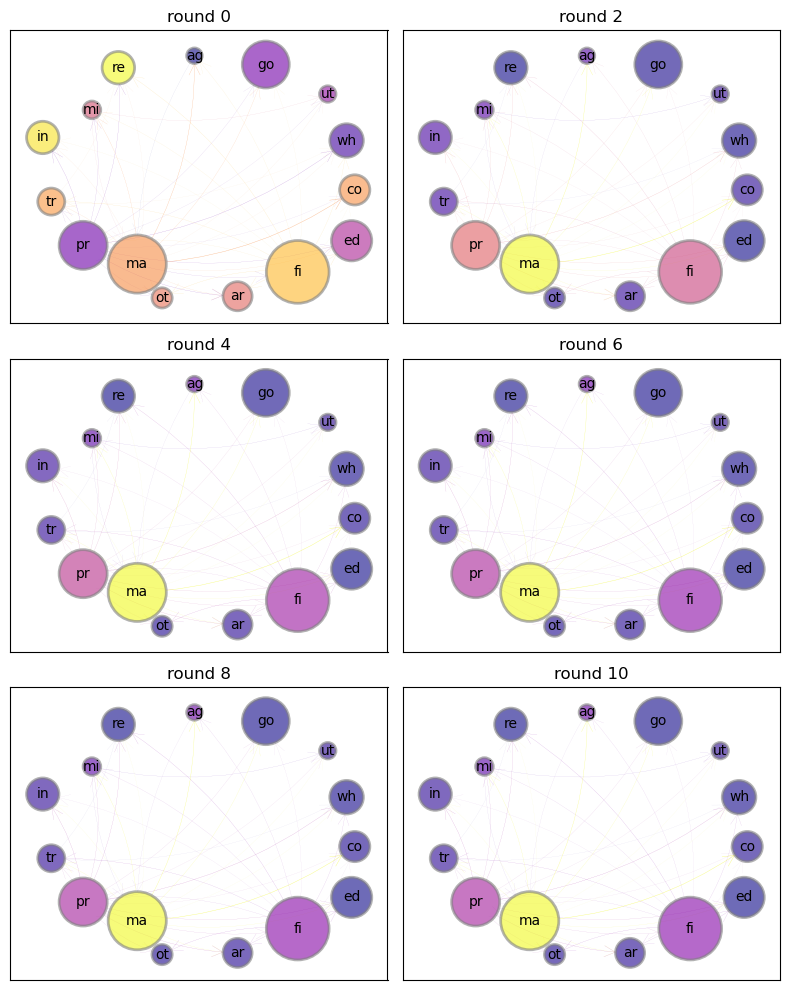

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for ax, x_vec, i in zip(axes, x_vecs, range(sim_length)):
    if i % 2 != 0:
        pass
    ax.set_title(f"round {i*2}")
    x_vec_cols = qbn_io.colorise_weights(x_vec,beta=False)
    # remove self-loops
    for i in range(len(A)):
        A[i][i] = 0
    qbn_plt.plot_graph(A, X, ax, codes,
                  layout_type='spring',
                  layout_seed=342156,
                  node_color_list=x_vec_cols,
                  node_size_multiple=0.00028,
                  edge_size_multiple=0.8)

plt.tight_layout()
plt.show()

## 4 Application ii: ranking sectors

If we study the input output networks via the graph theory, then we can specify the relative importance of sectors by the so-called centrality measures.

Historically, the most prominent example of a ranking mechanism for the internet is [PageRank](https://en.wikipedia.org/wiki/PageRank), which transformed Google from a minor start up to a technology behemoth.

In the view of graph theory the production network is called a weighted directed graph, which consists of
- a set of nodes, $V = [n]$,
- a set of directed edges, $E= \{(i, j) \in V \times V: a_{ij} >0 \}$,
- the adjacency matrix $A=(a_{ij})$, which is also the input-output coefficient matrix.

### 4.1 Eigenvector centrality

The eigenvector centrality of node $i$ is

$$
e_i = \frac{1}{r(A)} \sum_{1 \leq j \leq n} a_{ij} e_j
$$

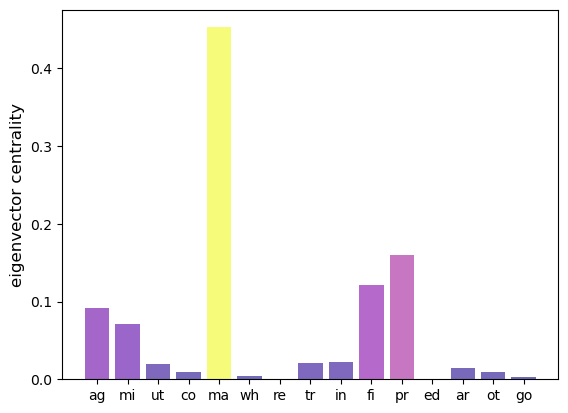

In [50]:
A, F = build_coefficient_matrices(Z, X)
centrality = qbn_io.eigenvector_centrality(A)

fig, ax = plt.subplots()
ax.bar(codes, centrality, color=color_list, alpha=0.6)
ax.set_ylabel("eigenvector centrality", fontsize=12)
plt.show()

A node with a higher eigenvector centrality means it is a more important supplier.

### 4.2 Output multiplier

The output multiplier of node $j$ is 

$$
\mu_j = \sum^n_{i=1} l_{ij} 
$$

It captures the total impact of a unit change of demand in $j$.

Write it in the matrix form 

$$
\mu^{\top} = \mathbb 1^{\top} L = \mathbb 1^{\top} (I- A)^{-1}
$$

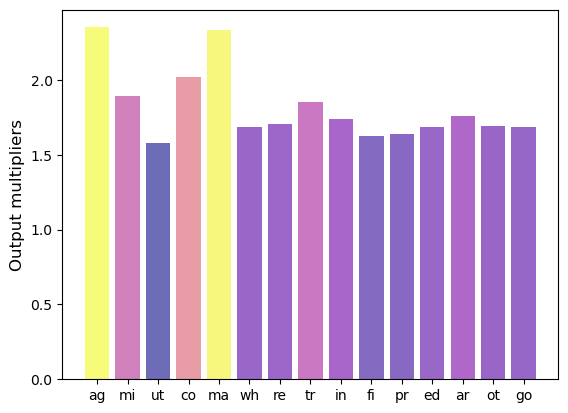

In [51]:
omult = qbn_io.katz_centrality(A, authority=True)

fig, ax = plt.subplots()
omult_color_list = qbn_io.colorise_weights(omult,beta=False)
ax.bar(codes, omult, color=omult_color_list, alpha=0.6)
ax.set_ylabel("Output multipliers", fontsize=12)
plt.show()

A node with a higher output multiplier indicates that it is a more significant buyer of intermediaries.

### 5 Application iii: visualising a production network

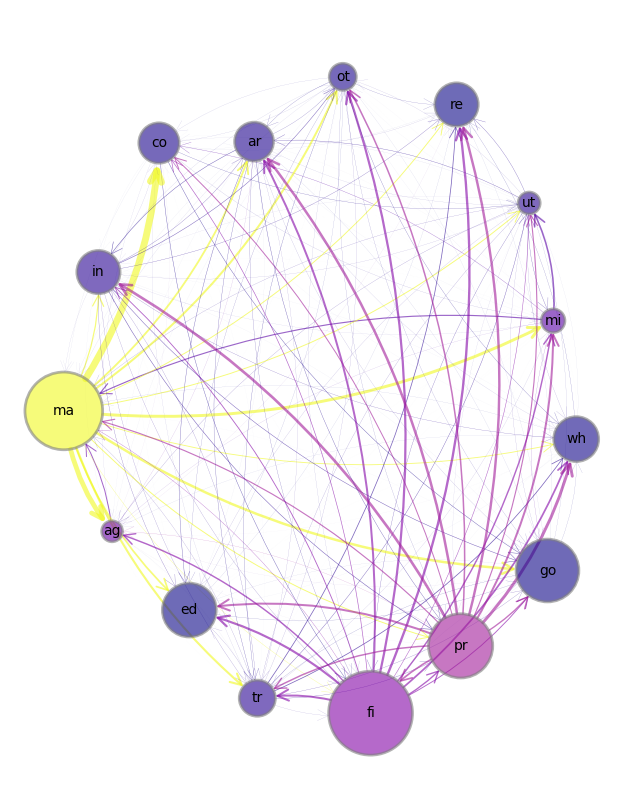

In [52]:
centrality = qbn_io.eigenvector_centrality(A)

# Remove self-loops
for i in range(A.shape[0]):
    A[i][i] = 0

fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")
color_list = qbn_io.colorise_weights(centrality,beta=False)

qbn_plt.plot_graph(A, X, ax, codes,
              layout_type='spring',
              layout_seed=5432167,
              tol=0.0,
              node_color_list=color_list)

plt.show()